<a href="https://colab.research.google.com/github/ljm524/esaa24-2/blob/main/esaa_hw1108.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [개념정리]

## PART 03 케라스(Keras)

### 01 딥러닝 준비

*   1-1 주요 용어
1. 하이퍼파라미터(hyper-parameter) : 학습 속도, 반복 훈련 횟수 등 -> 튜닝
2. 과소적합 vs. 과대적합(underfitting vs. overfitting)
> 과소적합 : 모델이 충분히 학습되지 않은 경우 예측 성능이 떨어짐
>
> 과대적합 : 학습 데이터를 지나치게 반복 학습하게 되어 과하게 적합되어 예측 데이터에 대한 예측 오차가 발생할 확률이 커짐
3. 에포크(epoch) : 딥러닝 모델이 반복 훈련을 할 때 데이터셋을 전부 학습에 사용하는 1회의 훈련 루프
4. 손실함수(loss function) : 에측 값과 정답 값의 차이 또는 오차
5. 경사하강법(gradient descent) : 딥러닝 모델을 훈련할 때, 모델 내부의 가중치에 대한 미분 값을 구하고 목적 함수 값이 낮아지는 방향으로 차감하면서 결국 최소 함수 값을 갖도록 하는 방법
*   1-2 딥러닝 프로세스
1. 데이터 전처리
2. 모델 생성
3. 모델 컴파일
4. 모델 훈련
5. 모델 검증
6. 모델 예측



### 02 단순 신경망 훈련

*   2-1 선형회귀
*   2-2 뉴런(Neuron)
*   2-3 Dense 레이어
*   2-4 데이터셋 만들기
*   2-5 Sequential API
1. 모델 구조
2. 입력 데이터 형태
3. 단순선형회귀 모델 정의
*   2-6 모델 요약
*   2-7 컴파일
*   2-8 훈련
*   2-9 검증
*   2-10 예측











### 03 심층 신경망으로 이미지 분류

*   3-1 케라스 내장 데이터셋 로드
*   3-2 데이터 전처리
*   3-3 Flatten 레이어
*   3-4 활성화 함수
*   3-5 입력과 출력
*   3-6 손실함수
*   3-7 옵티마이저
*   3-8 평가지표
*   3-9 훈련
*   3-10 평가
*   3-11 예측













# [필사]

In [ ]:
!pip install --upgrade tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation:

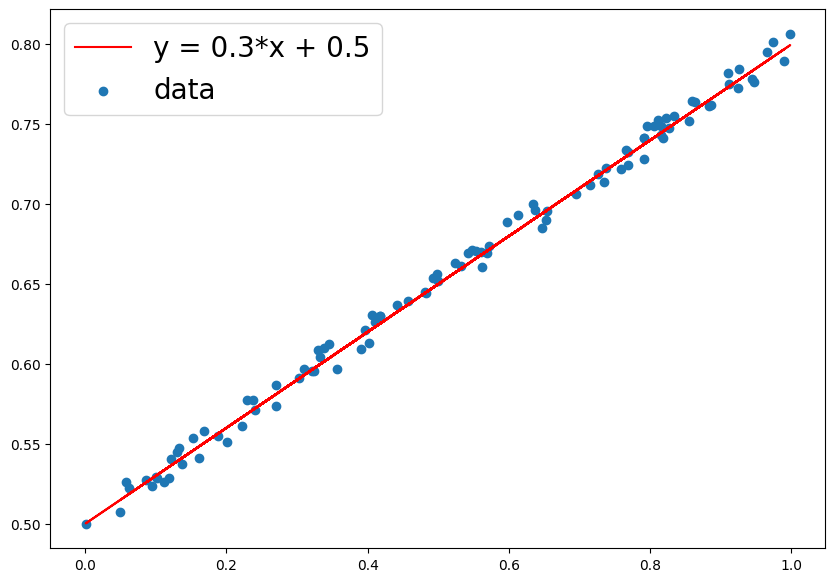

w: 0.3, b: 0.5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 샘플에 활용할 데이터 셋 만들기
def make_linear(w=0.5, b=0.8, size=50, noise=1.0):
    x = np.random.rand(size)
    y = w * x + b
    noise = np.random.uniform(-abs(noise), abs(noise), size=y.shape)
    yy = y + noise
    plt.figure(figsize=(10, 7))
    plt.plot(x, y, color='r', label=f'y = {w}*x + {b}')
    plt.scatter(x, yy, label='data')
    plt.legend(fontsize=20)
    plt.show()
    print(f'w: {w}, b: {b}')
    return x, yy

x, y = make_linear(w=0.3, b=0.5, size=100, noise=0.01)

In [ ]:
# 최대 반복 횟수
num_epoch = 1000

# 학습율 (learning_rate)
learning_rate = 0.005

# 에러 기록
errors = []

# random 한 값으로 w, b를 초기화 합니다.
w = np.random.uniform(low=0.0, high=1.0)
b = np.random.uniform(low=0.0, high=1.0)

for epoch in range(num_epoch):
    # Hypothesis 정의
    y_hat = w * x + b

    # Loss Function 정의
    error = 0.5*((y_hat - y) ** 2).sum()
    if error < 0.005:
        break
    # Gradient 미분 계산
    w = w - learning_rate * ((y_hat - y) * x).sum()
    b = b - learning_rate * (y_hat - y).sum()

    errors.append(error)

    if epoch % 5 == 0:
        print("{0:2} w = {1:.5f}, b = {2:.5f} error = {3:.5f}".format(epoch, w, b, error))

print("----" * 15)
print("{0:2} w = {1:.1f}, b = {2:.1f} error = {3:.5f}".format(epoch, w, b, error))

 0 w = 0.64181, b = 0.59519 error = 32.23744
 5 w = 0.48890, b = 0.39731 error = 0.15582
10 w = 0.46076, b = 0.41148 error = 0.11320
15 w = 0.43731, b = 0.42458 error = 0.08287
20 w = 0.41731, b = 0.43576 error = 0.06079
25 w = 0.40024, b = 0.44531 error = 0.04472
30 w = 0.38568, b = 0.45345 error = 0.03301
35 w = 0.37325, b = 0.46040 error = 0.02448
40 w = 0.36264, b = 0.46634 error = 0.01828
45 w = 0.35360, b = 0.47140 error = 0.01376
50 w = 0.34587, b = 0.47571 error = 0.01047
55 w = 0.33928, b = 0.47940 error = 0.00807
60 w = 0.33366, b = 0.48254 error = 0.00633
65 w = 0.32886, b = 0.48523 error = 0.00506
------------------------------------------------------------
66 w = 0.3, b = 0.5 error = 0.00485


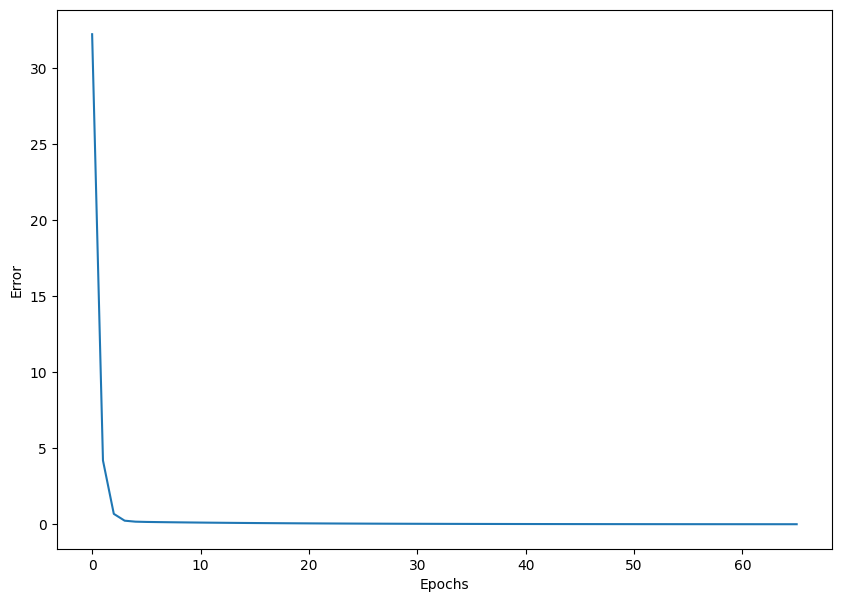

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [ ]:

import numpy as np

# 샘플 데이터셋 생성
x = np.arange(1, 6)

# y = 3x + 2
y = 3 * x + 2
print(x)
print(y)


[1 2 3 4 5]
[ 5  8 11 14 17]


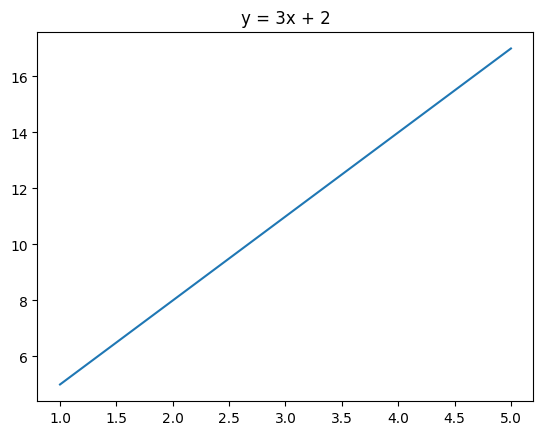

In [ ]:

import matplotlib.pyplot as plt

# 시각화
plt.plot(x, y)
plt.title('y = 3x + 2')
plt.show()

In [ ]:

import tensorflow as tf


In [ ]:

# 리스트형
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1),
])


In [ ]:
# add 함수로 레이어 추가
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Dense(5))
model.add(tf.keras.layers.Dense(1))

In [ ]:
import tensorflow as tf

In [ ]:

model = tf.keras.Sequential([
    # 입력 데이터의 shape = (150, 4) 인 경우 input_shape 지정
    tf.keras.layers.Dense(10, input_shape=[4]),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1),
])

In [ ]:

# 단순선형회귀 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[1])
])


In [ ]:

# 모델 요약
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 긴 문자열 지정
model.compile(optimizer='sgd', loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])

In [ ]:
# 짧은 문자열 지정
model.compile(optimizer='sgd', loss='mse', metrics=['mse', 'mae'])

In [ ]:
# 클래스 인스턴스 지정
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.005),
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError(),
                       tf.keras.metrics.MeanSquaredError()
                       ])

In [ ]:
# 컴파일
model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

In [ ]:
# 훈련
model.fit(x,y,epochs=5)

Epoch 1/5
1/1 [==============================] - 0s 492ms/step - loss: 248.4169 - mae: 14.5993
Epoch 2/5
1/1 [==============================] - 0s 14ms/step - loss: 144.8102 - mae: 11.1755
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 84.4330 - mae: 8.5617
Epoch 4/5
1/1 [==============================] - 0s 14ms/step - loss: 49.2479 - mae: 6.5663
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 28.7435 - mae: 5.0429


In [ ]:
# 단순 선형회귀 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[1])
])

# 컴파일
model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

# 훈련
history=model.fit(x,y,epochs=1200)

Epoch 1/1200
1/1 [==============================] - 0s 395ms/step - loss: 224.6871 - mae: 13.9002
Epoch 2/1200
1/1 [==============================] - 0s 17ms/step - loss: 130.9889 - mae: 10.6442
Epoch 3/1200
1/1 [==============================] - 0s 17ms/step - loss: 76.3858 - mae: 8.1585
Epoch 4/1200
1/1 [==============================] - 0s 15ms/step - loss: 44.5655 - mae: 6.2608
Epoch 5/1200
1/1 [==============================] - 0s 14ms/step - loss: 26.0219 - mae: 4.8120
Epoch 6/1200
1/1 [==============================] - 0s 14ms/step - loss: 15.2152 - mae: 3.7060
Epoch 7/1200
1/1 [==============================] - 0s 14ms/step - loss: 8.9173 - mae: 2.8615
Epoch 8/1200
1/1 [==============================] - 0s 11ms/step - loss: 5.2468 - mae: 2.2168
Epoch 9/1200
1/1 [==============================] - 0s 13ms/step - loss: 3.1075 - mae: 1.7245
Epoch 10/1200
1/1 [==============================] - 0s 15ms/step - loss: 1.8605 - mae: 1.3486
Epoch 11/1200
1/1 [=============================

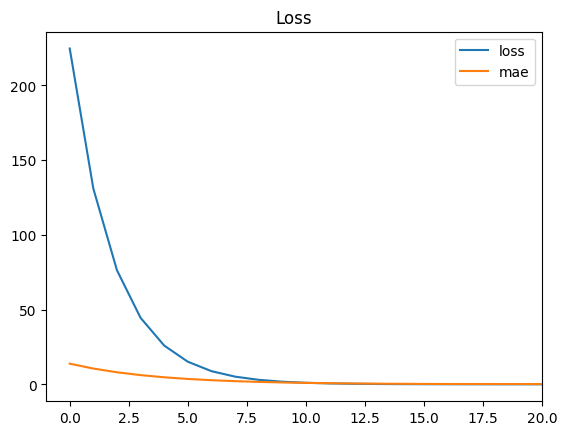

In [ ]:

import matplotlib.pyplot as plt

# 20 epoch까지 Loss 수렴에 대한 시각화
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['mae'], label='mae')
plt.xlim(-1, 20)
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# 검증
model.evaluate(x, y)

1/1 [==============================] - 0s 318ms/step - loss: 3.7641e-05 - mae: 0.0053


[3.764054417842999e-05, 0.005265998654067516]

In [ ]:
# 예측
model.predict([10])

1/1 [==============================] - 0s 237ms/step


array([[32.02545]], dtype=float32)

In [ ]:
import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

In [ ]:
# load_data()로 데이터셋 로드
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# 로드된 데이터셋 확인
print('train set:', x_train.shape, y_train.shape)
print('test set:', x_test.shape, y_test.shape)

train set: (60000, 28, 28) (60000,)
test set: (10000, 28, 28) (10000,)


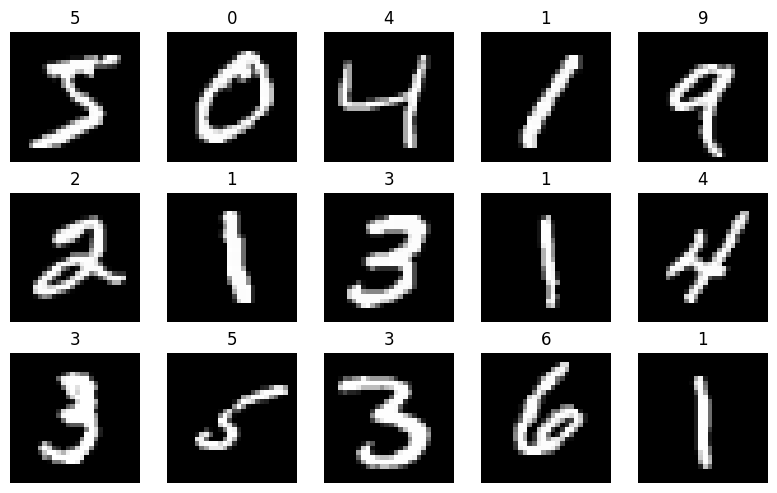

In [ ]:
# 데이터 시각화
import matplotlib.pyplot as plt

# canvas 생성
fig, axes = plt.subplots(3,5)
fig.set_size_inches(8,5)

for i in range(15):
    ax = axes[i//5, i%5]
    # imshow로 이미지 시각화
    ax.imshow(x_train[i], cmap='gray')
    ax.axis('off')
    ax.set_title(str(y_train[i]))
plt.tight_layout()
plt.show()

In [ ]:
# x_train 배열의 데이터 확인
x_train[0, 10:15, 10:15]

array([[  1, 154, 253,  90,   0],
       [  0, 139, 253, 190,   2],
       [  0,  11, 190, 253,  70],
       [  0,   0,  35, 241, 225],
       [  0,   0,   0,  81, 240]], dtype=uint8)

In [ ]:
# 픽셀 값의 최소/최대값 확인
print(f'정규화 전] 최소값: {x_train.min()}, 최대값: {x_train.max()}')

# 데이터 정규화
x_train = x_train / x_train.max()

# 정규화 후 최소/최대값 확인
print(f'정규화 후] 최소값: {x_train.min()}, 최대값: {x_train.max()}')

정규화 전] 최소값: 0, 최대값: 255
정규화 후] 최소값: 0.0, 최대값: 1.0


In [ ]:
# test 셋에도 정규화 동일 적용
x_test = x_test / x_test.max()

In [ ]:
# 변환 후 x_train 배열의 데이터 확인
x_train[0, 10:15, 10:15]

array([[0.00392157, 0.60392157, 0.99215686, 0.35294118, 0.        ],
       [0.        , 0.54509804, 0.99215686, 0.74509804, 0.00784314],
       [0.        , 0.04313725, 0.74509804, 0.99215686, 0.2745098 ],
       [0.        , 0.        , 0.1372549 , 0.94509804, 0.88235294],
       [0.        , 0.        , 0.        , 0.31764706, 0.94117647]])

In [ ]:
print(f'변경 전 shape: {x_train.shape}')
print(f'1D으로 shape 변경 후: {x_train.reshape(60000,-1).shape}')

변경 전 shape: (60000, 28, 28)
1D으로 shape 변경 후: (60000, 784)


In [ ]:
print(f'변경 전 shape: {x_train.shape}')

# Flatten 레이어 적용 후 shape 확인
print(f'Flatten 적용 후: {tf.keras.layers.Flatten()(x_train).shape}')

변경 전 shape: (60000, 28, 28)
Flatten 적용 후: (60000, 784)


In [ ]:
# Dense 레이어에 relu 활성화 함수를 적용한 경우
tf.keras.layers.Dense(128, activation='relu')

In [ ]:
# Dense 레이어와 relu 활성화 함수 레이어를 별도 적용한 경우
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu')
])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # 노드 = 10개(클래스 개수와 동일)
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# 출력층 노드 = 1인 경우, sigmoid
tf.keras.layers.Dense(1, activation='sigmoid')

# 출력층 노드 = 2개 이상인 경우, softmax
tf.keras.layers.Dense(10, activation='softmax')

In [ ]:
# 이진 분류(출력 노드 개수 = 1, sigmoid인 경우)
model.compile(loss='binary_crossentropy')

In [ ]:
# y가 원핫 벡터인 경우
# [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
model.compile(loss='categorical_crossentropy')
# y가 원핫 벡터가 아닌 경우
# [5]
model.compile(loss='sparse_categorical_crossentropy')

In [ ]:
# 클래스 인스턴스로 지정
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam)

# 문자열로 지정
model.compile(optimizer='adam')

In [ ]:
# 클래스 인스턴스로 지정
acc = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[acc])

In [ ]:
# 문자열로 지정
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 훈련
model.fit(x_train, y_train,
          # 검증 셋 지정
          validation_data = (x_test,y_test),
          epochs=10
          )

Epoch 1/10
1875/1875 [==============================] - 19s 9ms/step - loss: 0.2311 - accuracy: 0.9318 - val_loss: 0.1116 - val_accuracy: 0.9639
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0935 - accuracy: 0.9710 - val_loss: 0.1005 - val_accuracy: 0.9683
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0648 - accuracy: 0.9795 - val_loss: 0.0786 - val_accuracy: 0.9764
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0511 - accuracy: 0.9842 - val_loss: 0.0785 - val_accuracy: 0.9784
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0397 - accuracy: 0.9875 - val_loss: 0.0896 - val_accuracy: 0.9750
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0309 - accuracy: 0.9905 - val_loss: 0.0906 - val_accuracy: 0.9766
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0292 - accuracy: 0.9909 - val_loss: 0.0776 - val_ac

In [ ]:
# 검증
test_loss, test_acc = model.evaluate(x_test, y_test)

print('검증 셋 정확도:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0714 - accuracy: 0.9831
검증 셋 정확도: 0.9830999970436096


In [ ]:
# 예측
predictions = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [ ]:
# 예측 결과 출력
predictions[0]

array([1.7103754e-12, 7.4623969e-08, 9.9818198e-10, 2.0032181e-10,
       2.3986189e-09, 1.7796538e-07, 1.1285774e-17, 9.9999875e-01,
       1.5269504e-10, 1.0014387e-06], dtype=float32)

In [ ]:
import numpy as np

# 0번 index에 대한 예측 클래스 출력
print(np.argmax(predictions[0]))

# 첫 10개 index에 대한 예측 클래스 출력
print(np.argmax(predictions[:10],axis=1))

7
[7 2 1 0 4 1 4 9 5 9]


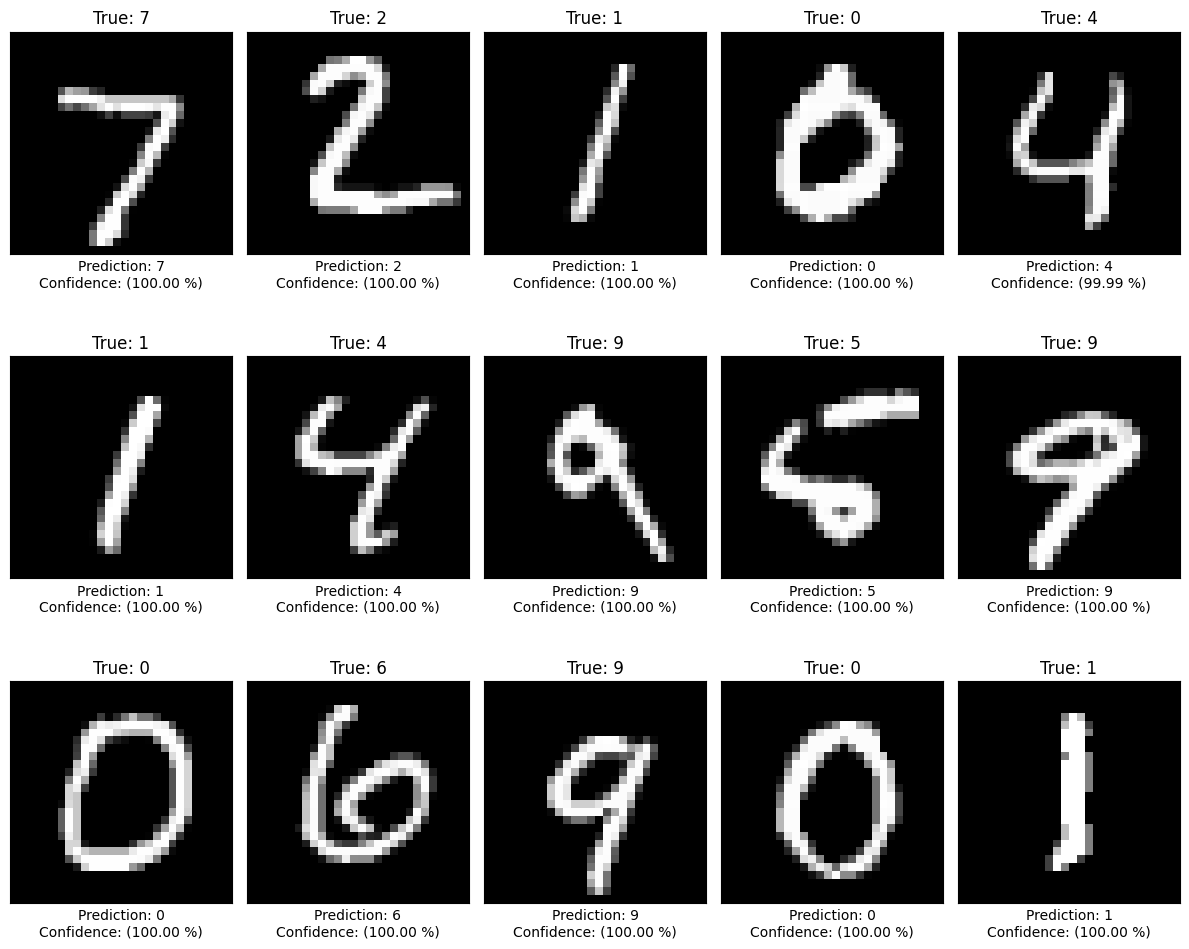

In [ ]:
# 데이터 시각화
import matplotlib.pyplot as plt
def get_one_result(idx):
    img, y_true, y_pred, confidence = x_test[idx], y_test[idx], np.argmax(predictions[idx]), 100 * np.max(predictions[idx])
    return img, y_true, y_pred, confidence
# canvas 생성
fig, axes = plt.subplots(3,5)
fig.set_size_inches(12,10)
for i in range(15):
    ax = axes[i//5, i%5]
    img, y_true, y_pred, confidence = get_one_result(i)
    # imshow로 이미지 시각화
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'True: {y_true}')
    ax.set_xlabel(f'Prediction: {y_pred}\nConfidence: ({confidence:.2f} %)')
plt.tight_layout()
plt.show()